# 'EpiSimPy': Epidemiological Simulation using Python

This Python project primarily focuses on using the ***SIR*** (susceptible-infected-removed) model to simulate the spread of a general disease. This model incorporates ***Differential Equations*** to simulate the behavior of the three compartments during an epidemic period. We explore both theoretical and practical aspects of disease spread, drawing comparisons between different simulated scenarios. We also integrate real-world factors, including ***quarantine measures, travel dynamics, and the influence of crowded places*** like supermarkets or schools.


By incorporating these practical considerations, our aim is to mirror the complexities of real epidemic scenarios. The exploration of travel dynamics and quarantine measures reveals the profound impact of population movement and intervention strategies on overall disease spread. Additionally, the presence of crowded places highlights how localized conditions can significantly influence transmission rates. These elements play a pivotal role in either accelerating or mitigating the spread of the disease, resulting in insights that are both valuable and open to interpretation.


In expanding our model, we introduced the ***SIRS*** (Susceptible-Infected-Removed-Susceptible) model, accounting for the ***loss of immunity post-recovery***. This extension mirrors real-world situations, such as the ***COVID-19*** pandemic. In the SIRS model, individuals, after recovering, can become susceptible again, introducing the possibility of reinfection. This dynamic loop captures the essence of scenarios where immunity wanes over time."

## Part 1 - SIR model

The initial part focuses on analyzing the behavior of the differential equations in the SIR model, a critical step for comprehending the significance of its parameters.

In simulating the spread of a disease, two main parameters, $\gamma$ and $\beta$, play pivotal roles:

1) ***Recovery Rate ($\gamma$)***: Represents the speed at which individuals recover from the illness. $1/\gamma$ provides an average duration for recovery, offering insights into the healing process.
2) ***Infection Rate ($\beta$)***: Indicates how easily the disease spreads from an infected individual to others. Reflects the number of people a single infected person can potentially infect.


The key metric, $R_0 = \frac{\beta}{\gamma}$, characterizes the behavior of the pandemic:
1) $R_0$ > 1 : Epidemic enviroment.
2) $R_0$ = 1 : Endemic enviroment.
3) $R_0$ < 1 : No spread of infection.

The differential equations under study are:

\begin{align}
\dot S &= -\beta\frac{SI}{N} \quad \text{(Rate of change of susceptible individuals)} \nonumber \\
\dot I &= \beta\frac{SI}{N} - \gamma I \quad \text{(Rate of change of infected individuals)} \nonumber \\
\dot R &= \gamma I \quad \text{(Rate of change of recovered individuals)} \nonumber
\end{align}

These equations capture the dynamic interactions between susceptible (S), infected (I), and recovered (R) individuals within the population, forming the foundation for understanding the progression of an epidemic.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import odeint
from IPython.display import HTML
import random as rnd
import matplotlib.patches as patches
from scipy.optimize import curve_fit

In [2]:
class Humanity:
    def __init__(self, N1, N2,recovery_time,infecting_rate):
        self.N1 = N1  # number of people in x-direction
        self.N2 = N2  # number of people in y-direction
        self.N = N1 * N2  # total number of people
        self.susceptible = N1 * N2  # initial number of susceptible people
        self.infected = 0
        self.removed = 0
        self.time = 0
        self.state_matrix = np.zeros((N1, N2))  # matrix representing the state of each person:
                                                # 0 - susceptible
                                                # -1 - infected
                                                # 1 - recovered 
        self.list_of_ill_people = {}  # in this dictionary:
                                      # key - the place of an ill human
                                      # value - how many time units he is ill (sick_time)
        self.susceptible_history = []  # list to store susceptible population over time
        self.infected_history = []  # list to store infected population over time
        self.removed_history = []  # list to store removed population over time
        
        #calculating beta for DE
        self.beta = [0]
        #GAMMA
        self.recovery_time = recovery_time
        self.healing_matrix = 1/np.random.exponential(1/recovery_time, size=(N1,N2)) #recovery_time +np.zeros((N1,N2))
        
        self.infecting_rate = infecting_rate

    def __call__(self, place):
        return self.state_matrix
    
    def evolution(self):
        self.susceptible_history.append(self.susceptible)
        self.infected_history.append(self.infected)
        self.removed_history.append(self.removed)
        self.time += 1
           
        self.infect_people()
        self.recover_people()
        
    def infect_people(self):
        new_ill = 0

        a = list(self.list_of_ill_people.keys())
        S = self.susceptible
        self.beta.append(0);
        for i in a:
            n, m = i
            for j in range(n - 1, n + 2):
                if j == -1 or j == self.N1:
                    continue  # for those people whose place is at the borders of the state_matrix
                              # to avoid list index out of range error
                for k in range(m - 1, m + 2):
                    if k == -1 or k == self.N2:
                        continue  # for those people whose place is at the borders of the state_matrix
                                  # to avoid list index out of range error
                    if self.state_matrix[j][k] == 0 and np.random.random() <= self.infecting_rate: 
                        self.infect((j, k))
                        new_ill+=1
        #calculate beta only if there are ill people and there are many suceptible people
        if len(a) >0 and self.susceptible>0: 
            self.beta[-1] = new_ill/len(a)/S*self.N;

    
    def recover_people(self):
        a = list(self.list_of_ill_people.keys())
        for i in a:
        ## Generate a random number to represent the probability of healing
        ## Check if the random probability is less than the overall heal probability
            n, m = i
            if self.list_of_ill_people[i] >= self.healing_matrix[n][m]:
                self.heal(i)
            else:
                self.list_of_ill_people[i] += 1
            
    def infect(self, place):
        n, m = place
        self.susceptible -= 1
        self.infected += 1
        self.state_matrix[n][m] = -1
        self.list_of_ill_people.update({place: 0})                         

    def heal(self, place): 
        n, m = place              
        self.infected -= 1
        self.removed += 1
        self.state_matrix[n][m] = 1
        self.list_of_ill_people.pop(place)
     

    def plot(self,ax,title):
        ax.plot(self.susceptible_history, label='Susceptible', color='blue')
        ax.plot(self.removed_history, label='Removed', color='green')
        ax.plot(self.infected_history, label='Infected', color='red')
        ax.set_xlabel('Days')
        ax.set_ylabel('Population')
        ax.legend()
        ax.set_title(title)
    
    def run_model(self,fig, ax,fps,  nSeconds,title):
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        text = ax.text(0, N1+8, '', ha='left', va='center', fontsize=11)
        tx = ax.set_title('Frame 0')

        def animate(i):

            ax.imshow(self.state_matrix, cmap='gray', vmin=-1, vmax=1)  
            self.evolution() 
            text.set_text(f'beta: {self.beta[-1]:.2f}, gamma: {1/self.recovery_time:.2f}, R0: {self.beta[-1]*self.recovery_time:.2f}')
            tx.set_text('Frame {0}'.format(i))

        anim = animation.FuncAnimation(
                                       fig, 
                                       animate, 
                                       frames = nSeconds * fps,
                                       init_func=None,
                                       interval = 1000/fps, # in ms
                                       )
        anim.save(title, fps=fps)

class Differential_SIR: # Initialization of the class for solving differential equations 
    def __init__(self, N, initial_infected):
        self.N = N
        self.initial_susceptible = N
        self.initial_infected = initial_infected
        self.initial_removed = 0


    def sir_model(self, y, t, beta, gamma,delta): # Function defining the SI model differential equations
        S, I, R = y
        b = beta[int(t)] if isinstance(beta,list) else beta
        dSdt = -b* S * I/self.N
        dIdt = b * S * I/self.N - gamma * I
        dRdt = gamma * I
        return [dSdt, dIdt, dRdt]

    def run_simulation(self, beta, gamma, days,ax,title, label_suffix='',delta = 0): # Function to run the differential equation simulation
        t = np.linspace(0, days, days+1)
        y0 = [self.initial_susceptible, self.initial_infected, self.initial_removed]
        result = odeint(self.sir_model, y0, t, args=(beta, gamma,delta))
        S, I, R = result.T
        ax.set_xlabel('Days')
        ax.set_ylabel('Population')
        ax.set_title(title)
        ax.plot(t, S, label=f'Susceptible {label_suffix}', linestyle='-.', color='blue')
        ax.plot(t, I, label=f'Infected {label_suffix}', linestyle='-.', color='red')
        ax.plot(t, R, label=f'Recovered {label_suffix}', linestyle='-.', color='green')
        ax.legend()
    
    def steepest_descent(self,I,R,beta_0,gamma_0,alpha,step,error,max_iteration,days):
        iteration = 0
        beta = beta_0
        gamma = gamma_0
        I_t = lambda x,gamma: self.fit_func(x,gamma,days)[1]
        R_t = lambda beta,x: self.fit_func(beta,x,days)[2]
        It = I_t(beta,gamma)
        Rt = R_t(beta,gamma)
        dI = I_t(beta + step,gamma) - It
        dR = R_t(beta,gamma + step) - Rt
        dif_chi2_I = -np.sum((I-It)*dI/step)
        dchi_I = np.sum((I-It)**2)
        dif_chi2_R = -np.sum((R-Rt)*dR/step)
        dchi_R = np.sum((R-Rt)**2)
        d_chi = np.sqrt(dif_chi2_I**2 + dif_chi2_R**2)
        while d_chi > error:
            beta += -alpha*dif_chi2_I
            gamma += -alpha*dif_chi2_R
            It = I_t(beta,gamma)
            Rt = R_t(beta,gamma)
            dI = I_t(beta + step,gamma) - It
            dR = R_t(beta,gamma + step) - Rt
            dif_chi2_I = -np.sum((I-It)*dI/step)
            dchi_I = np.sum((I-It)**2)
            dif_chi2_R = -np.sum((R-Rt)*dR/step)
            dchi_R = np.sum((R-Rt)**2)
            d_chi = np.sqrt(dif_chi2_I**2 + dif_chi2_R**2)
            iteration+=1
            if iteration > max_iteration:
                return beta,gamma
        return beta,gamma
        
    def fit_func(self, beta,gamma,days):
        t = np.linspace(0, days, days+1)
        y0 = [self.initial_susceptible, self.initial_infected, self.initial_removed]
        result = odeint(self.sir_model, y0, t, args=(beta, gamma,0))
        S, I, R = result.T
        return S,I,R    
    

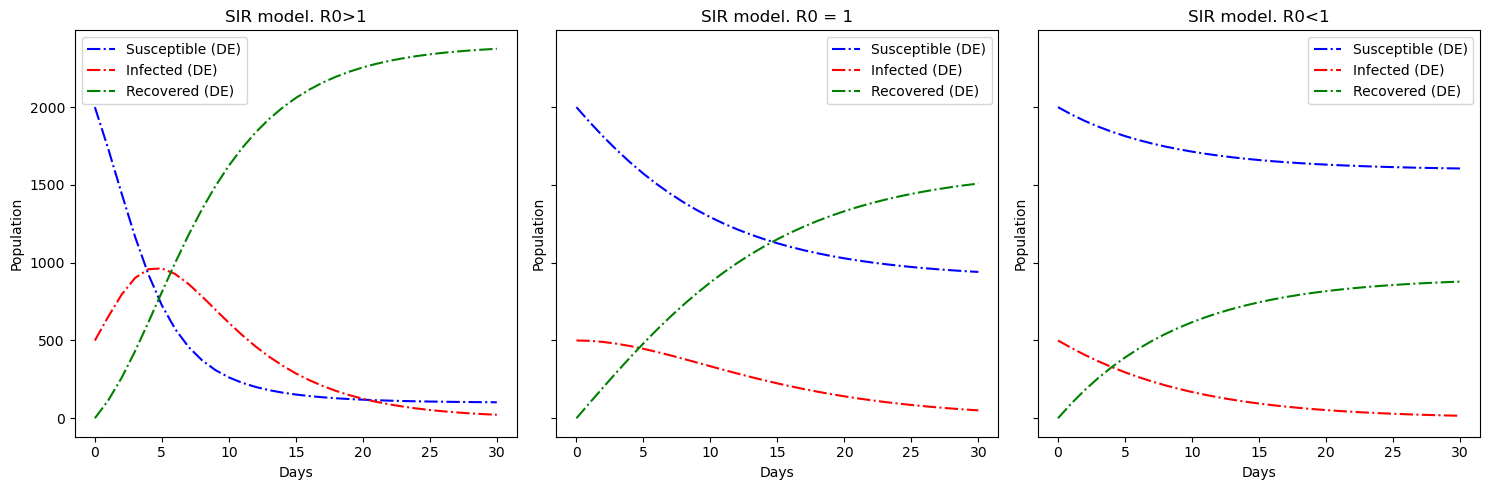

In [3]:
N1 = 50
N2 = 50
fig, ax_model = plt.subplots(1,3, figsize=(15, 5), sharey=True)

# virus_parameters:
infecting_rate = 0.5
recovery_time = 5
beta_sir = infecting_rate
gamma_sir = 1 / recovery_time

Differential_equation = Differential_SIR(N1 * N2 - 500, initial_infected=500)

Differential_equation.run_simulation(beta_sir , gamma_sir, days=30, ax=ax_model[0], label_suffix='(DE)',title = "SIR model. R0>1")  # R0 > 1
Differential_equation.run_simulation(beta_sir - 0.3, gamma_sir, days=30, ax=ax_model[1], label_suffix='(DE)',title = "SIR model. R0 = 1")  # R0 = 1
Differential_equation.run_simulation(beta_sir - 0.4, gamma_sir, days=30, ax=ax_model[2], label_suffix='(DE)',title = "SIR model. R0<1")  # R0 < 1

plt.tight_layout()
plt.show()

The plotted data clearly indicates that when the basic reproduction number (R0) exceeds 1, the epidemic initiates a significant spread, manifesting as a peak in the number of infected individuals.

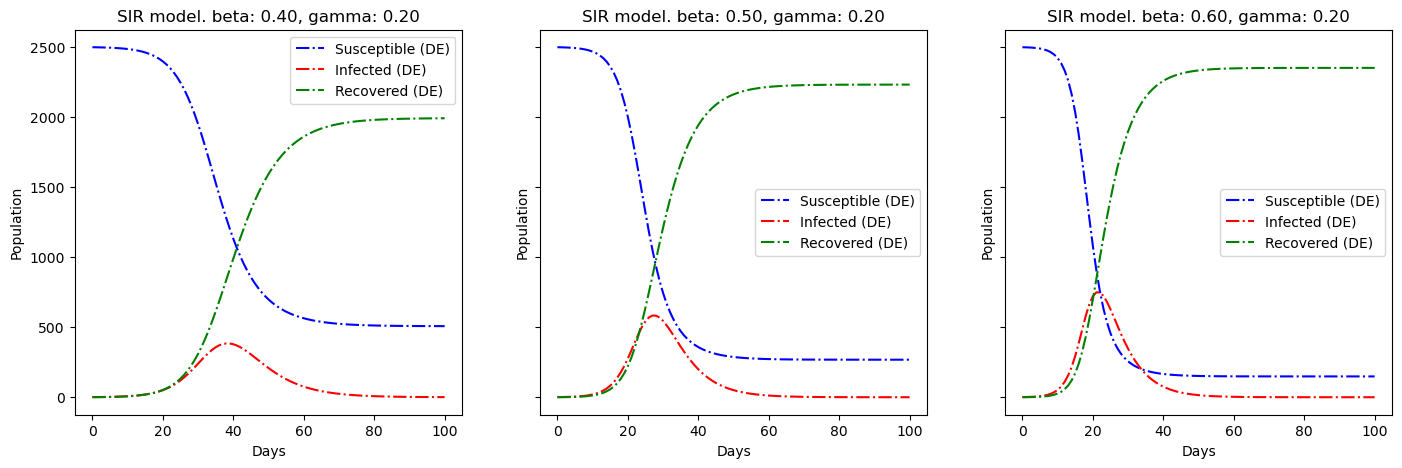

In [4]:
N1 = 50
N2 = 50
fig, ax_model = plt.subplots(1, 3, figsize=(17, 5),sharey=True)

# virus_parameters:
infecting_rate = 0.5
recovery_time = 5
beta_sir = [infecting_rate-0.1,infecting_rate,infecting_rate+0.1]
gamma_sir = [1 / recovery_time - 0.1,1 / recovery_time,1 / recovery_time + 0.1]

Differential_equation = Differential_SIR(N1 * N2 - 1, initial_infected=1)

for i in range(len(beta_sir)): Differential_equation.run_simulation(beta_sir[i],gamma_sir[1],days=100, ax=ax_model[i], label_suffix='(DE)',\
                                                                    title = f"SIR model. beta: {beta_sir[i]:.2f}, gamma: {gamma_sir[1]:.2f}") 



The plotted data illustrates a clear correlation between the infection rate and the number of infected individuals. As the infection rate rises, there is a corresponding increase in the number of people who become infected.

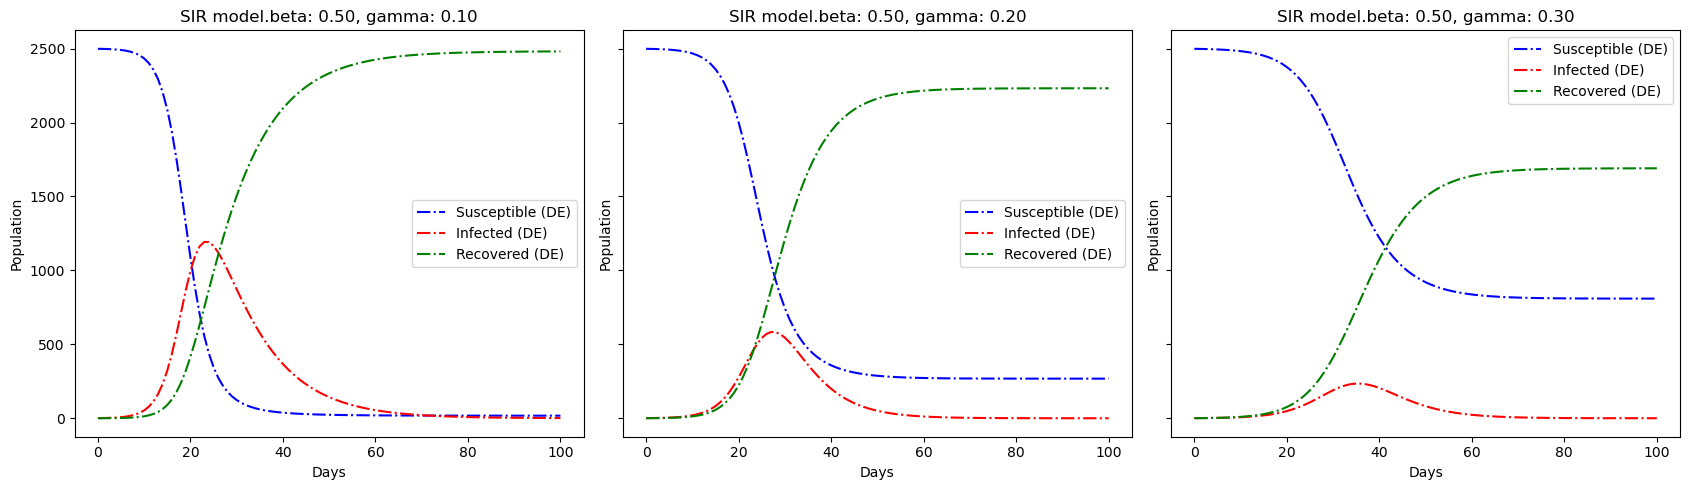

In [5]:
fig, ax_model = plt.subplots(1, 3, figsize=(17, 5),sharey=True)
for i in range(len(gamma_sir)): Differential_equation.run_simulation(beta_sir[1],gamma_sir[i],days=100, ax=ax_model[i], label_suffix='(DE)',\
                                                                     title = f"SIR model.beta: {beta_sir[1]:.2f}, gamma: {gamma_sir[i]:.2f}") 
plt.tight_layout()
plt.show()

The plot above shows the influence of the recovery rate. A higher recovery rate means that infected individuals recover more quickly, reducing the duration of their infectiousness. This, in turn, limits the overall spread of the infection and leads to a decline in the number of infected people over time.
To address our specific task, we devised an approximation method for beta and gamma using a steepest descent approach.

MovieWriter ffmpeg unavailable; using Pillow instead.


0.8606563675186906 0.0688482416035042


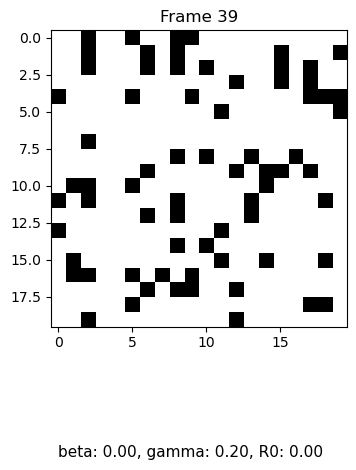

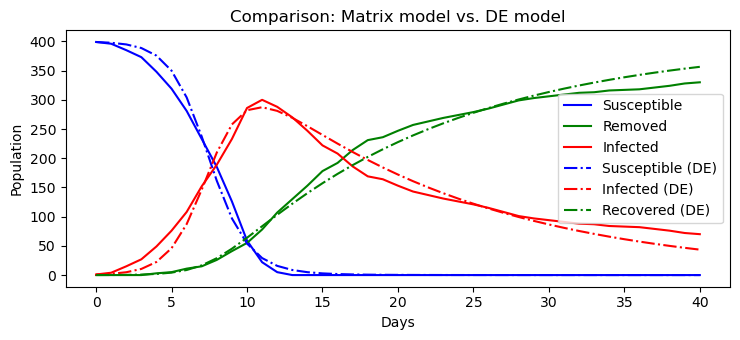

In [5]:
# Real Simulation
N1 = 20
N2 = 20
fps = 10; nSeconds = 4
fig, ax = plt.subplots(1,1)

people = Humanity(N1, N2,recovery_time,infecting_rate)
people.infect((round(N1/2),round(N2/2)))

people.run_model(fig,ax,fps, nSeconds,title = "SIR matrix model.gif")

fig_model, ax_model = plt.subplots(1,1)
people.plot(ax_model,title = "Comparison: Matrix model vs. DE model")  

#Differential Equation Simulation
Differential_equation = Differential_SIR(N1*N2-1, initial_infected=1)

S = people.susceptible_history
I = people.infected_history
R = people.removed_history
t = [i for i in range(len(S))]

beta_sir = infecting_rate
beta_0 = beta_sir
gamma_sir = 1/recovery_time
gamma_0 = gamma_sir
step = 10**-4
alpha = 10**-8
error = 10000
max_iteration = 1000
days= nSeconds*fps
beta_sir,gamma_sir = Differential_equation.steepest_descent(I,R,beta_0,gamma_0,alpha,step,error,max_iteration,days)
print(beta_sir,gamma_sir)
Differential_equation.run_simulation(beta_sir, gamma_sir, days= fps*nSeconds,ax = ax_model, label_suffix='(DE)',title = "Comparison: Matrix model vs. DE model")


Above, we have generated the plot comparing the results of the matrix model with the differential equations. The good fit between the results of the matrix model and the differential equations suggests that the matrix model accurately captures the essential dynamics of the epidemic. 

In the following model, we introduce a different approach, treating the population as a gas of moving particles. The population is represented by an instance of the HumanityGas class, which, in turn, contains a list of individuals, each represented by the HumanGas class. Each person in this model can move with a specified speed and follows a random turning trajectory, ensuring that the average position of the human remains constant.
This modeling approach simulates the real-life movement of individuals within a defined boundary, such as a neighborhood. 
The spread of the virus is influenced by three key parameters:

1) Infect radius: This parameter signifies the range within which an infected individual can potentially transmit the virus to others. It encapsulates the spatial extent of contagious interactions.
2) Recovery time &
3) Infecting rate are described as per the pervious models 
As the model evolves, individuals become infected based on their proximity to others within the infect radius of an infected person. Infected individuals have the potential to recover if they remain ill for a duration equal to the specified recovery time. The recovery process follows an exponential distribution. 


In [7]:

class HumanityGas:
    def __init__(self, N,edge_pos, Lx, Ly, v,rotate_time,\
                 recovery_time,infecting_rate,infect_radius,atractors = None, switch_time = None,\
                     quarantine_pos = None,quarantine_Lx = None,quarantine_Ly = None,\
                         quarantine_time = None,quarantine_volume = None):
        self.time = 0
        self.edge_pos = edge_pos
        self.N = N
        self.Lx = Lx
        self.Ly = Ly
        self.list_of_infected = []
        #each boarder defined by the point that belongs to the border and the vector perpendicular to the border 
        self.boarders = [[np.array([edge_pos[0],edge_pos[1]]),np.array([1,0])],\ 
                         [np.array([edge_pos[0],edge_pos[1] + Ly]),np.array([0,-1])],\
                         [np.array([edge_pos[0] + Lx,edge_pos[1]]),np.array([-1,0])],\
                         [np.array([edge_pos[0],edge_pos[1]]),np.array([0,1])]]
        self.list_of_suceptible = [HumanGas(v,rotate_time,[edge_pos[0] + rnd.uniform(0, Lx),\
                                edge_pos[1] + rnd.uniform(0, Ly)],recovery_time) for i in range(N)]
        self.S = self.N
        self.I = 0
        self.R = 0
        self.list_of_removed = []
        self.susceptible_history = []  # list to store susceptible population over time
        self.infected_history = []  # list to store infected population over time
        self.removed_history = []  # list to store removed population over time
        
        self.beta = [0]
        self.recovery_time = recovery_time
        self.infect_radius = infect_radius
        self.infecting_rate = infecting_rate
        
        self.atractors = None if atractors == None else [Atractor(i[0],i[1],i[2]) for i in atractors]
        self.switch_time = switch_time
        self.atractors_state = 0
        
        self.quarantine = None if quarantine_Lx == None else Quarantine(quarantine_pos,\
                                quarantine_Lx,quarantine_Ly,quarantine_time,quarantine_volume,recovery_time)

  
    def evolution(self):
        self.time += 1
        self.susceptible_history.append(self.S + self.quarantine.S if self.quarantine!=None else self.S)
        self.infected_history.append(self.I + self.quarantine.I if self.quarantine!=None else self.I)
        self.removed_history.append(self.R + self.quarantine.R if self.quarantine!=None else self.R)
    
        for i in self.list_of_suceptible + self.list_of_infected + self.list_of_removed:
            i.move(self)
        self.infect_people()
        self.recover_people()
        
        if self.switch_time != None:
            if self.time % self.switch_time ==0:
                self.switch_atractors()
            
            if self.atractors_state !=0:
                for i in self.atractors:
                    for j in self.list_of_infected + self.list_of_removed + self.list_of_suceptible:
                        Fx,Fy = i.calculate_forse(j)
                        if self.atractors_state == 1: j.move(self,Fx,Fy)
                        if self.atractors_state == -1: j.move(self,-Fx,-Fy)
        
        if self.quarantine != None:
            q = self.quarantine
            q.time+=1
            if self.time % q.quarantine_time == 0 and self.I > 2*q.quarantine_volume:
                q.send_to_quarantine(self)
            for j in q.list_of_infected + q.list_of_removed:
                j.move(q)
            q.recover_people(self)
                
        
    
    def infect_people(self):
        a = self.list_of_infected.copy()
        S = self.S
        self.beta.append(0);
        new_ill = 0
        for i in a:
            b = self.list_of_suceptible.copy()
            for j in b:
                dist = j.distance(i)
                if dist<self.infect_radius and np.random.random() < self.infecting_rate:
                        #j.ill_contact_time = 0
                        self.infect(j)
                        new_ill +=1

        if len(a) >0 and self.S>0: 
            self.beta[-1] = new_ill/len(a)/S*self.N;
            b = self.beta[-1]
    
    def recover_people(self):
        a = self.list_of_infected.copy()
        for i in a:
            if  i.sick_time == self.recovery_time:
                self.recover(i)
            else:
                i.sick_time +=1

    def infect(self, i):
        self.I+=1
        self.list_of_infected.append(i)
        self.S-=1
        self.list_of_suceptible.remove(i)

    def recover(self, i):
        self.I-=1
        self.list_of_infected.remove(i)
        self.R+=1
        self.list_of_removed.append(i)
        
    def coefficients(self):
        gamma = 1/self.recovery_time
        #print (beta)
        return gamma, self.beta[1:]

    def switch_atractors(self):
        if self.atractors_state == 0: self.atractors_state = 1; return
        if self.atractors_state == 1: self.atractors_state = -1; return
        if self.atractors_state == -1: self.atractors_state = 0; return
    
    def animate_planet(self,fig,ax,fps, nSeconds,title):
        self.draw_boarders(ax)
        # Set the figure size and adjust the padding between and around the subplots
        plt.rcParams["figure.figsize"] = [15, 10]
        plt.rcParams["figure.autolayout"] = True
        colors = ['red','black','gray']
        lines = [ax.scatter([],[],c = colors[i],s=4) for i in range(3)]
        text = ax.text(self.edge_pos[0],self.edge_pos[1]-self.Ly/5, '', ha='left', va='center', fontsize=11)
        
        if self.quarantine != None:
            self.quarantine.draw_boarders(ax)
            quarantine_lines = [ax.scatter([],[],c = colors[i],s=4) for i in range(3)]
            ax.set_xlim(self.edge_pos[0]-self.Lx/10,self.quarantine.edge_pos[0] + self.quarantine.Lx*11/10)
        else:
            ax.set_xlim(self.edge_pos[0]-self.Lx/10,self.edge_pos[0] + self.Lx*11/10)
        ax.set_ylim(self.edge_pos[1]-self.Ly/10,self.edge_pos[1] + self.Ly*11/10)
        tx = ax.set_title('Time 0')

        def animate(i):
            self.create_frame(lines)
            if self.quarantine!= None:
                if self.quarantine.N >0:
                    self.quarantine.create_frame(quarantine_lines)
            self.evolution() # Update the data
            text.set_text(f'beta: {self.beta[-1]:.2f}, gamma: {1/self.recovery_time:.2f}, R0: {self.beta[-1]*self.recovery_time:.2f}')
            tx.set_text('Time {0}'.format(i))
            return lines



        anim = animation.FuncAnimation(
                                       fig, 
                                       animate, 
                                       frames = nSeconds * fps,
                                       interval = 1000/fps, # in ms
                                       #blit = True
                                       )

        anim.save(title, fps=fps)
    
    def create_frame(self,lines): 
        x_data = [[self.list_of_infected[i].pos[0] for i in range(len(self.list_of_infected))] ,\
                 [self.list_of_suceptible[i].pos[0] for i in range(len(self.list_of_suceptible))] ,\
                 [self.list_of_removed[i].pos[0] for i in range(len(self.list_of_removed))]] 

        y_data = [[self.list_of_infected[i].pos[1] for i in range(len(self.list_of_infected))] ,\
                 [self.list_of_suceptible[i].pos[1] for i in range(len(self.list_of_suceptible))] ,\
                 [self.list_of_removed[i].pos[1] for i in range(len(self.list_of_removed))]]

        for i in range(3): lines[i].set_offsets(np.c_[x_data[i],y_data[i]])

        return lines
    
    def draw_boarders(self,ax):
        dx = self.Lx; dy = self.Ly
        for i in self.boarders:
            if i[1][0] == 0:
                x = [i[0][0],i[0][0] +dx]
                y = [i[0][1],i[0][1]]
            if i[1][1] == 0:
                x = [i[0][0],i[0][0]]
                y = [i[0][1],i[0][1]+dy]
            ax.plot(x,y)
        
    def plot(self,ax,title):
        #y = self.susceptible_history[::nHoursADay]
        ax.plot(self.susceptible_history, label='Susceptible', color='blue')
        #y = self.removed_history[::nHoursADay]
        ax.plot(self.removed_history, label='Removed', color='green')
        #y = self.infected_history[::nHoursADay]
        ax.plot(self.infected_history, label='Infected', color='red')
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.legend()
        ax.set_title(title)   
                

class HumanGas:
    
    def __init__(self, v,rotate_time,traj_center,recovery_time):
        self.sick_time = 0
        self.recovery_time = 1/rnd.expovariate(recovery_time)
        self.v = v
        self.rotate_time = rotate_time
        self.pos = [traj_center[0], traj_center[1]]
        self.phi = rnd.uniform(-np.pi,np.pi)

    
    def move(self,people, Fx = 0,Fy = 0,random_move = True):
        b, K = self.dist_to_boarders(people)
        if b:
            if K[0] == 1 and K[1] ==0:
                self.phi = 0
            elif K[0] == -1 and K[1] ==0:
                self.phi = np.pi
            elif K[0] == 0 and K[1] == 1:
                self.phi = np.pi/2
            elif K[0] == 0 and K[1] ==-1:
                self.phi = -np.pi/2

            self.pos[0] += 3*self.v*K[0]
            self.pos[1] += 3*self.v*K[1]
        else:
            if random_move:
                if people.time % self.rotate_time == 0:
                    self.phi = rnd.uniform(-np.pi,np.pi)
                self.pos[0] += self.v*np.cos(self.phi) + Fx
                self.pos[1] += self.v*np.sin(self.phi) + Fy
            else:
                self.phi = np.arccos(Fx/np.sqrt(Fx**2+Fy**2))
                self.pos[0] += Fx
                self.pos[1] += Fy
                

         
    def dist_to_boarders(self,people):
        errx = 3*self.v #people.Lx/people.nx/10
        erry = 3*self.v #people.Ly/people.ny/10
        for i in people.boarders:
            dr = np.array(self.pos) - i[0]
            if i[1][0] == 0:
                if np.abs(dr[0] - people.Lx/2)<= people.Lx/2 + errx and\
                    np.abs(dr[1]) <=erry:
                        return True, i[1]
            if i[1][1] == 0:
                if np.abs(dr[1] - people.Ly/2)<= people.Ly/2+ erry and\
                    np.abs(dr[0]) <=errx:
                        return True, i[1]
        return False, None
    
    def distance(self, human):
        x = self.pos[0]; y = self.pos[1]
        x0 = human.pos[0]; y0 = human.pos[1]
        return np.sqrt((x-x0)**2+(y-y0)**2)

class Atractor:
    def __init__(self,pos,force_const,radius):
        self.pos = pos
        self.force_const = force_const
        self.radius = radius
        
    
    def calculate_forse(self,human):
       dr = np.array(human.pos) - np.array(self.pos)
       dist = np.sqrt(dr[0]**2 + dr[1]**2)
       if dist < self.radius: return (0.,0.)
       else: return (-np.exp(-dist/self.force_const)*2*human.v*dr[0]/dist,\
                     -np.exp(-dist/self.force_const)*2*human.v*dr[1]/dist)
class Quarantine(HumanityGas):
    
    def __init__(self,edge_pos,Lx,Ly, quarantine_time, quarantine_volume,recovery_time):
        self.time = 0
        self.beta = [0]
        self.edge_pos = edge_pos
        self.Lx = Lx
        self.Ly = Ly
        self.boarders = [[np.array([edge_pos[0],edge_pos[1]]),np.array([1,0])],\
                         [np.array([edge_pos[0],edge_pos[1] + Ly]),np.array([0,-1])],\
                         [np.array([edge_pos[0] + Lx,edge_pos[1]]),np.array([-1,0])],\
                         [np.array([edge_pos[0],edge_pos[1]]),np.array([0,1])]]
        self.quarantine_time = quarantine_time
        self.quarantine_volume = quarantine_volume
        self.S = 0;self.I = 0; self.R = 0;self.N = 0
        self.list_of_suceptible = []
        self.list_of_infected = []
        self.list_of_removed = []
        self.recovery_time = recovery_time
    
    def send_to_quarantine(self,people):
        for i in range(self.quarantine_volume):
            index = np.random.randint(0, people.I - 1)
            quarantined = people.list_of_infected[index]
            
            people.list_of_infected.remove(quarantined)
            people.I -= 1
            people.N-=1
            quarantined.pos = [self.edge_pos[0] + rnd.uniform(0,self.Lx),\
                               self.edge_pos[1] + rnd.uniform(0,self.Ly)]
            self.list_of_infected.append(quarantined)
            self.I += 1
            self.N +=1
    
    def recover_people(self,people):
        super().recover_people()
        if self.R >0:
            for i in self.list_of_removed:
                self.list_of_removed.remove(i)
                self.R -=1
                self.N -=1
                i.pos = [people.edge_pos[0] + rnd.uniform(0,people.Lx),\
                                people.edge_pos[1] + rnd.uniform(0,people.Ly)]
                people.list_of_removed.append(i)
                people.R +=1

MovieWriter ffmpeg unavailable; using Pillow instead.


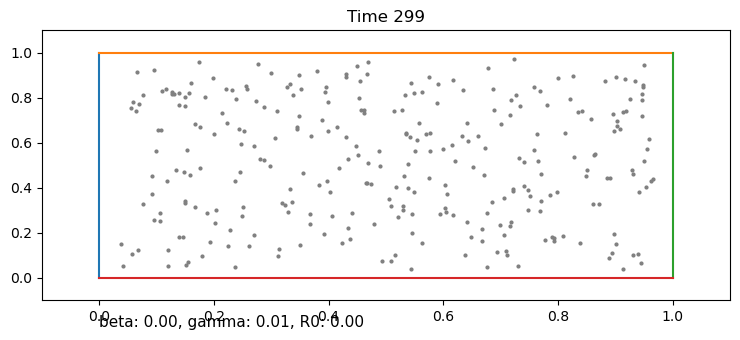

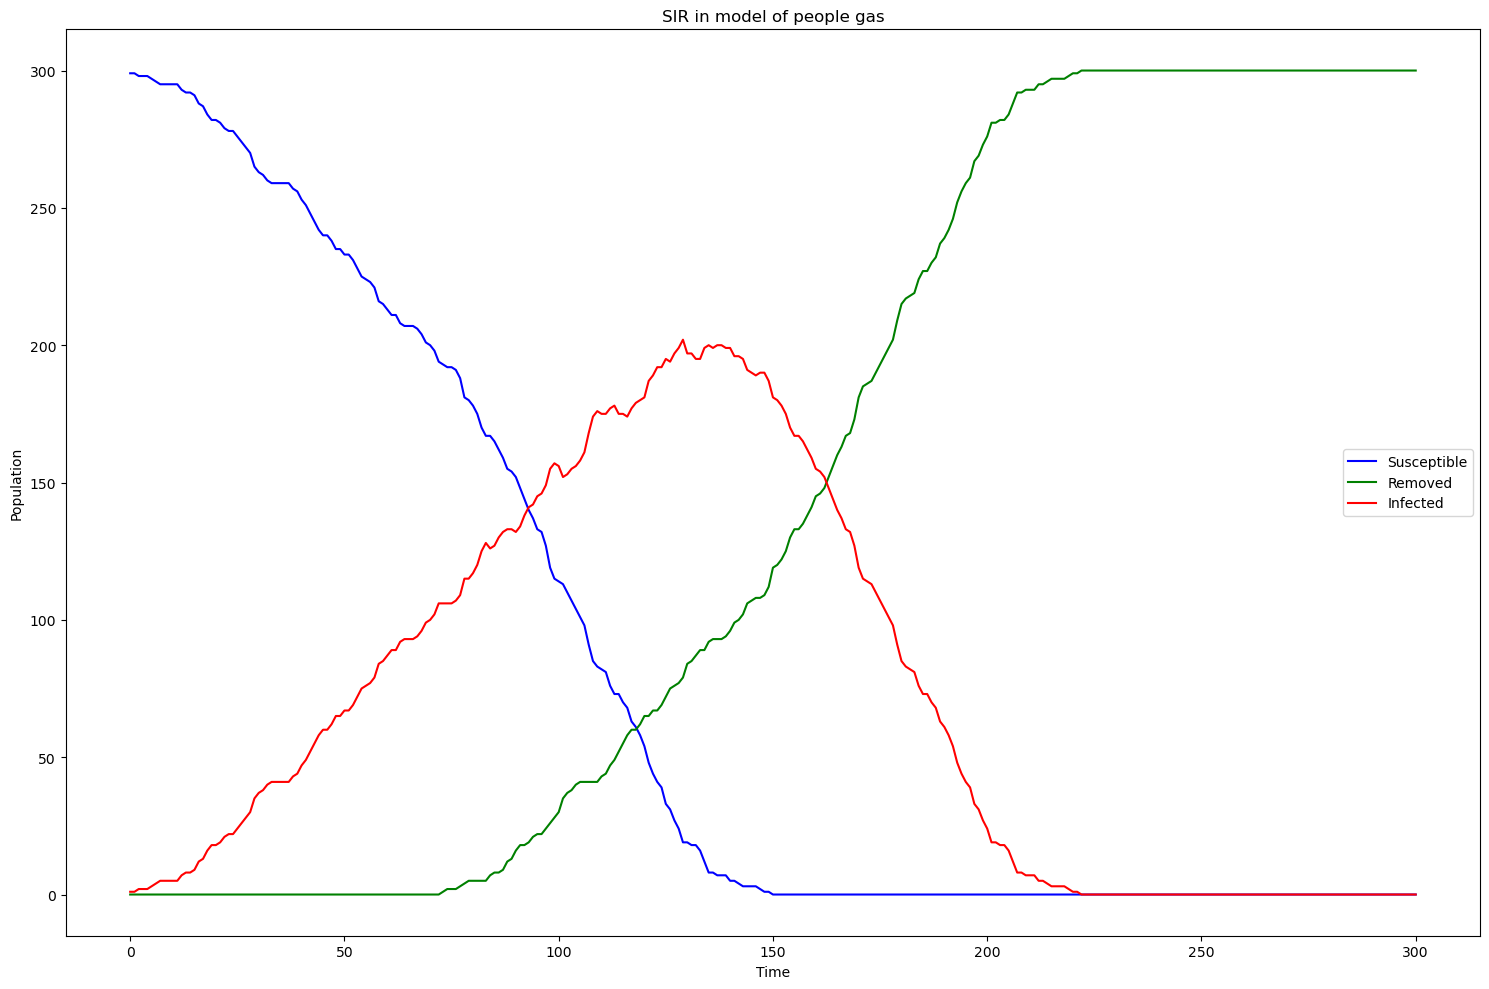

In [8]:


nHoursADay = 24
v = 0.01;rotate_time = 10

#parameters_of_the_world
N = 300;edge_pos = np.array([0.,0.]); Lx = 1; Ly = 1;

#virus_parameters
infect_radius = np.sqrt(Lx*Ly/N)/2;
recovery_time = 3*nHoursADay; infecting_rate = 0.8;

fps = 15; nSeconds = 20

fig, ax = plt.subplots(1,1)
people = HumanityGas(N,edge_pos,Lx,Ly,v,rotate_time,recovery_time,infecting_rate,infect_radius)
people.infect(people.list_of_suceptible[round(N/2)])

people.animate_planet(fig,ax,fps,nSeconds,title = "SIR people gas-no effect.gif")


fig_model, ax_model = plt.subplots(1,1)
people.plot(ax_model,title = 'SIR in model of people gas') 

Next, we incorporate the concept of attractors. In the context of this model, attractors can be interpreted as busy locations, such as supermarkets or schools. These attractors have the ability to draw people towards them, influencing their movement for a defined duration and subsequently releasing them. An analogous scenario could be a school during regular operating hours.

In the event that an infected individual appears at an attractor, there exists the potential for them to transmit the infection to others present at that location.
The code explores the impact of attractors on the dynamics of the model, considering the potential for increased interactions and transmission within attractor zones. Attractors are encapsulated within the Attractor class, featuring key parameters such as the position of the attractor and the attractive radius, signifying the effective range of attraction.

Three scenarios are visualized:

1)With Attractors in state 1: Individuals are attracted to the attractors.

2)With Attractors in state -1: Individuals are repelled by the attractors, reflecting a scenario analogous to students dispersing after school.

3)With Attractors in state 0: Attractors are turned off, resulting in no specific influence on individuals' movement.

The parameter switch_time determines the duration of each state. 

The animation and plots offer a visual representation of how the presence of attractors influences the spread of infection within the population. A notable increase in infected individuals is observed in areas with attractors, symbolizing public spaces.

MovieWriter ffmpeg unavailable; using Pillow instead.


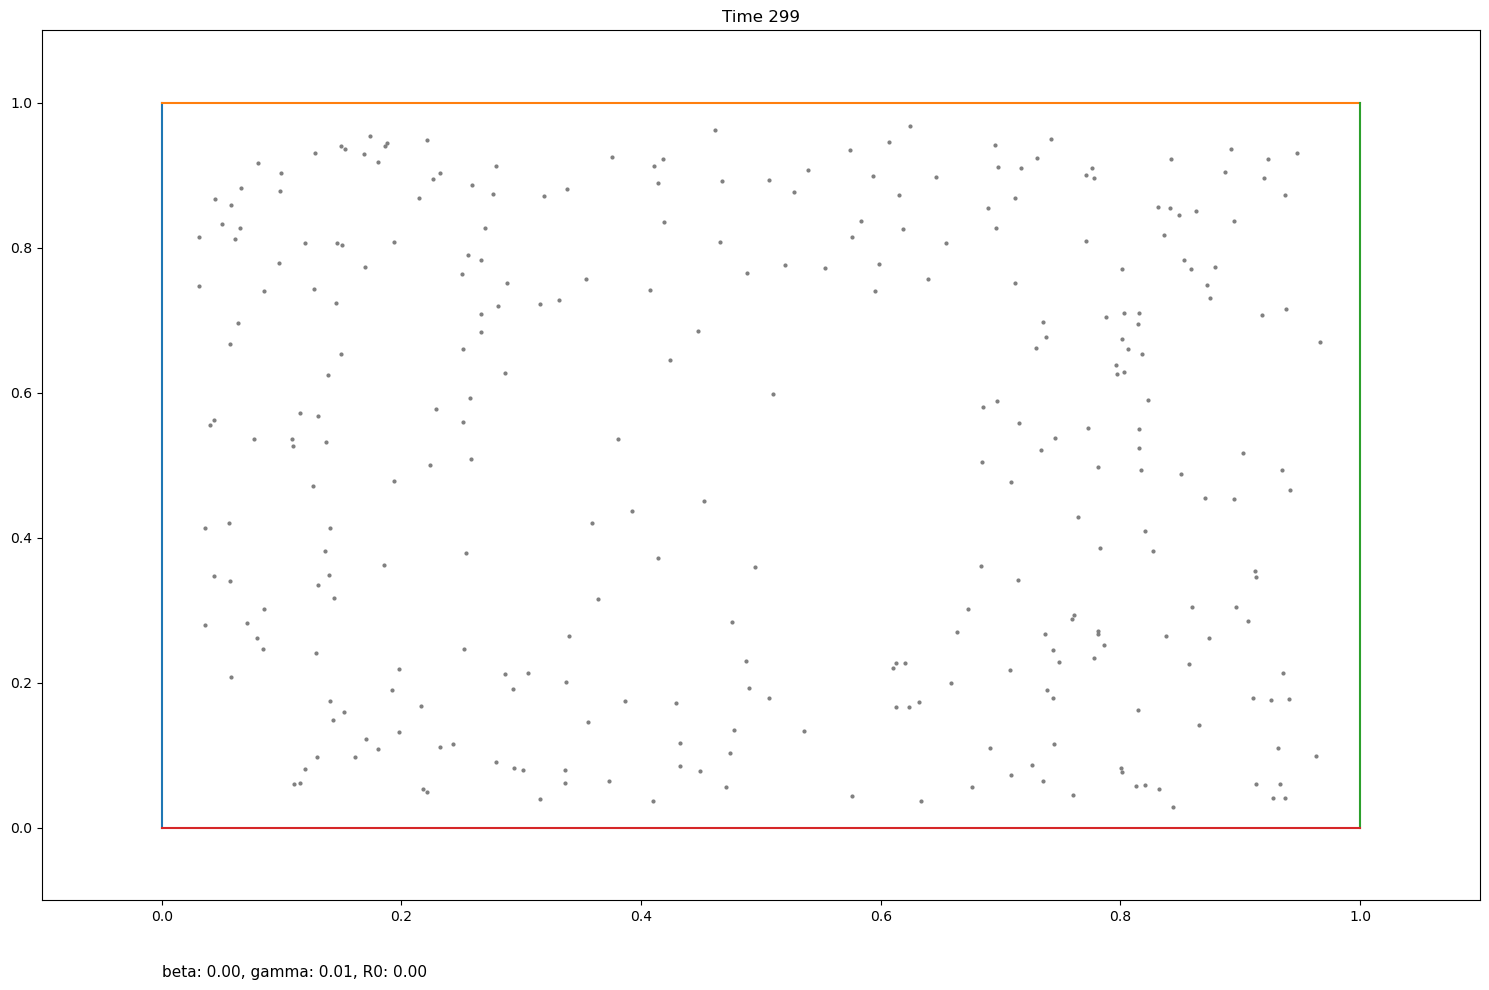

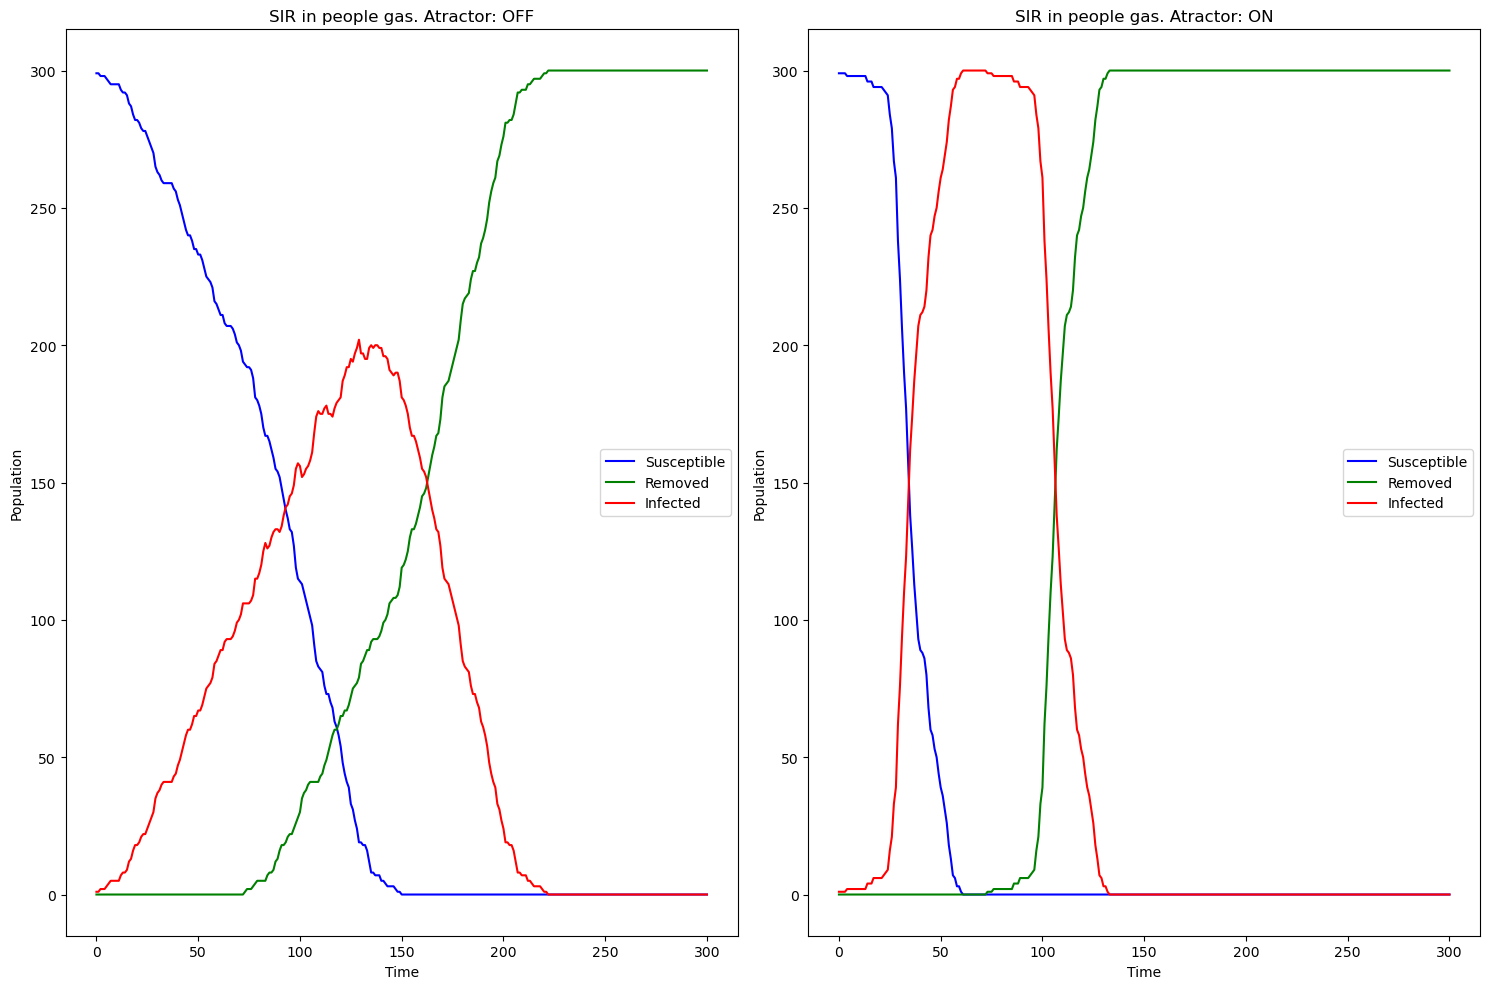

In [9]:
#atractor_parameters
atractors = [[[0.3,0.5],0.3,0.01],[[0.6,0.5],0.4,0.01]]
switch_time = round(nHoursADay)

fig, ax = plt.subplots()
people1 = HumanityGas(N,edge_pos,Lx,Ly,v,rotate_time,recovery_time,infecting_rate,infect_radius,atractors,switch_time)

people1.infect(people1.list_of_suceptible[round(N/2)])


people1.animate_planet(fig,ax,fps,nSeconds,title = "SIR people gas-Atractor.gif")

fig_model, ax_model = plt.subplots(1,2)
people.plot(ax_model[0], title = "SIR in people gas. Atractor: OFF") 
people1.plot(ax_model[1], title = "SIR in people gas. Atractor: ON")

Expanding on the model, we incorporate the concept of a quarantine zone. The quarantine zone, represented by an instance of the Quarantine class, becomes operational when the number of infected individuals surpasses a predefined threshold, denoted as the quarantine volume. Key parameters defining the quarantine include its position (quarantine_edge_pos), size, the time between two quarantine events(quarantine_time), and the number of individuals taken during each quarantine event (quarantine_volume).

The code then produces separate plots, visually comparing the impact of the quarantine on the progression of the infection. These visualizations serve as a means to assess and understand the influence of the quarantine strategy in mitigating the spread of the infection. 

MovieWriter ffmpeg unavailable; using Pillow instead.


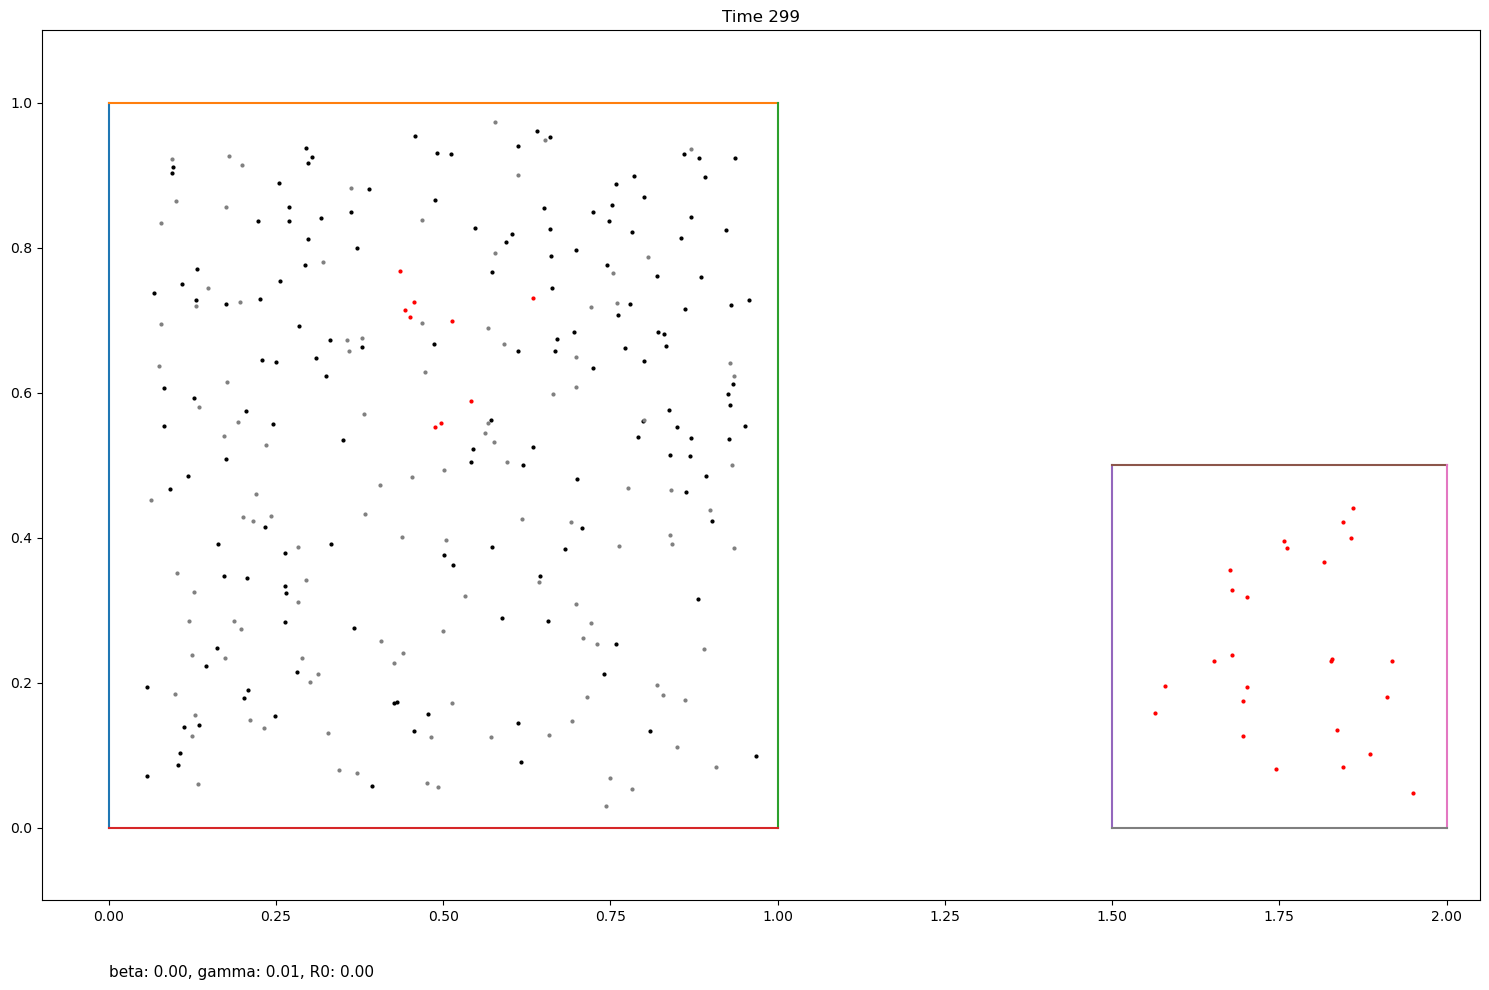

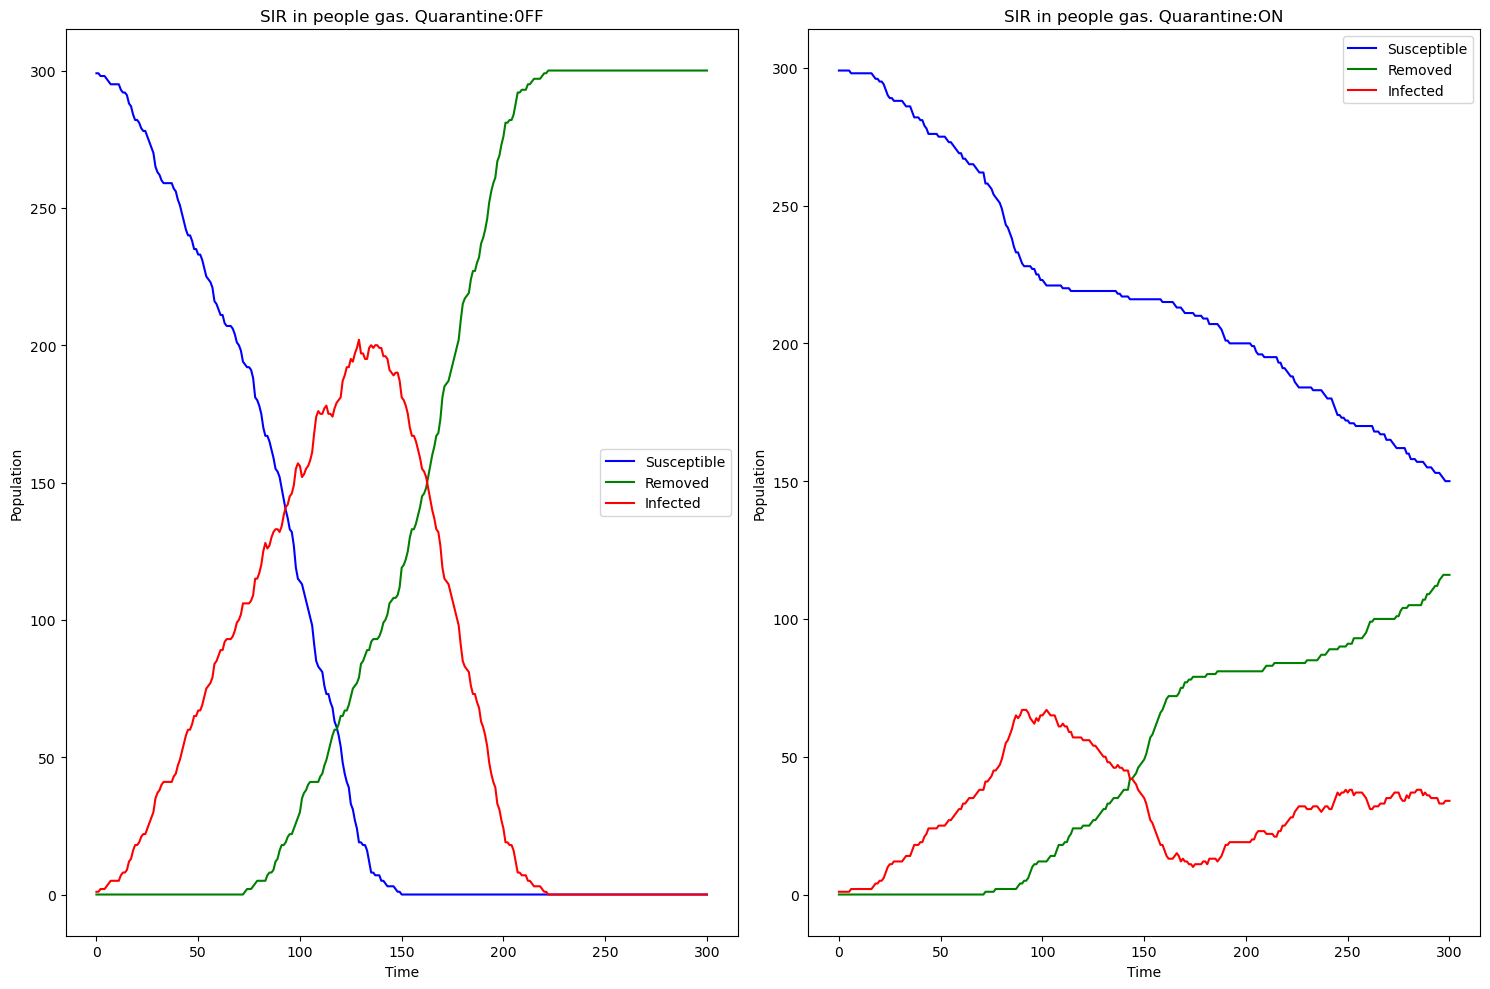

In [10]:
#quarantine_parameters
quarantine_edge_pos = np.array([1.5,0.]);quarantine_Lx = 0.5; quarantine_Ly = 0.5;
quarantine_time = 5; quarantine_volume = 5

fig, ax = plt.subplots()
people1 = HumanityGas(N,edge_pos,Lx,Ly,v,rotate_time,recovery_time,infecting_rate,infect_radius,\
     None,None,quarantine_edge_pos,quarantine_Lx,quarantine_Ly,quarantine_time,quarantine_volume)

N = len(people1.list_of_suceptible)
people1.infect(people1.list_of_suceptible[round(N/2)])


people1.animate_planet(fig,ax,fps,nSeconds,title = "SIR people gas-Quarantine.gif")

fig_model, ax_model = plt.subplots(1,2)
people.plot(ax_model[0], title = "SIR in people gas. Quarantine:0FF") 
people1.plot(ax_model[1], title = "SIR in people gas. Quarantine:ON") 

On checking the influence of both attractor and quarantine, we find that the effect of attractor is greater, and the effect of quarantine is negligible. 

MovieWriter ffmpeg unavailable; using Pillow instead.


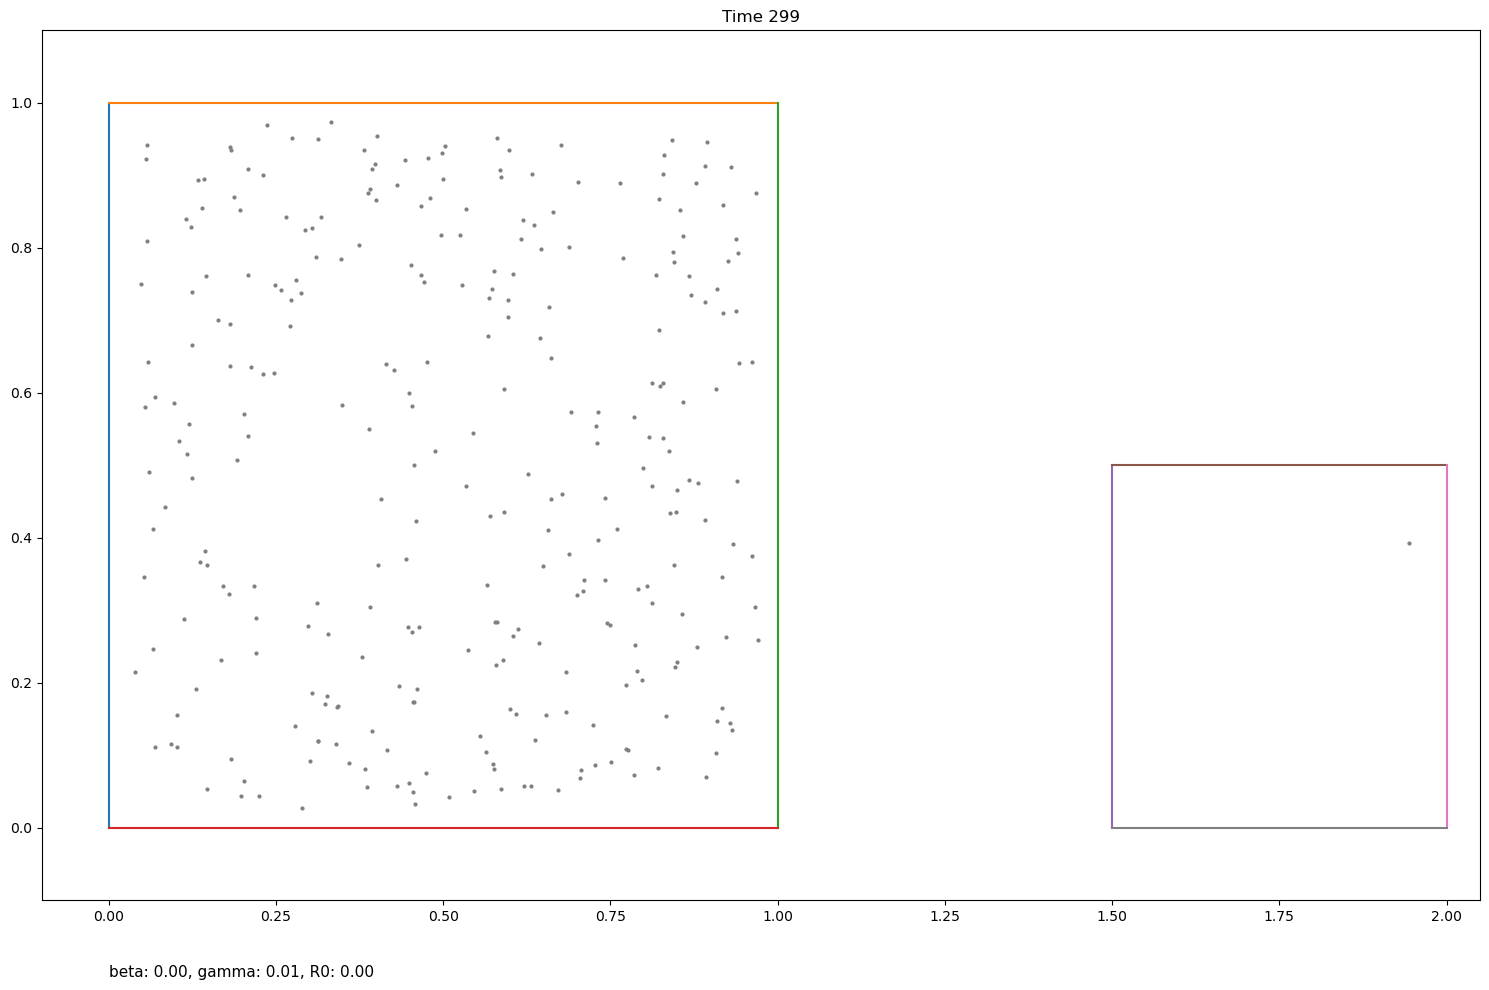

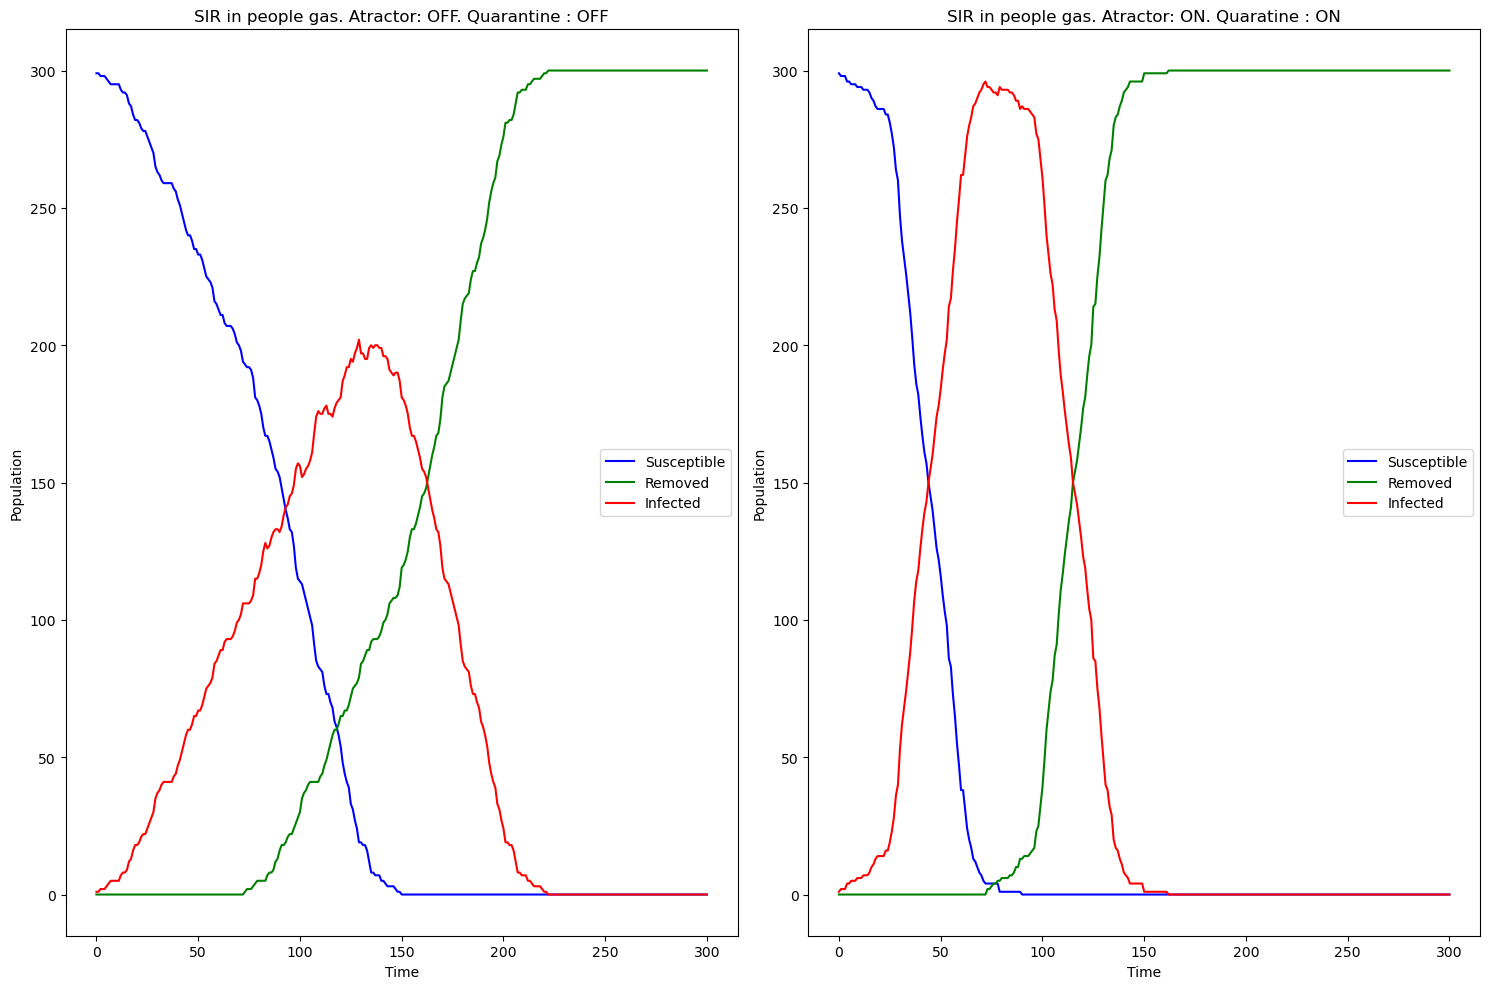

In [11]:
#atractor + quarantine parameters
atractors = [[[0.3,0.5],0.3,0.01]]
quarantine_volume = 10
fig, ax = plt.subplots()
people1 = HumanityGas(N,edge_pos,Lx,Ly,v,rotate_time,recovery_time,infecting_rate,infect_radius,atractors,switch_time, quarantine_edge_pos,quarantine_Lx,quarantine_Ly,quarantine_time,quarantine_volume)

people1.infect(people1.list_of_suceptible[round(N/2)])


people1.animate_planet(fig,ax,fps,nSeconds,title = "SIR people gas-Atractor+quarantine.gif")

fig_model, ax_model = plt.subplots(1,2)
people.plot(ax_model[0], title = "SIR in people gas. Atractor: OFF. Quarantine : OFF") 
people1.plot(ax_model[1], title = "SIR in people gas. Atractor: ON. Quarantine : ON")

The effect of ***traveling*** people is also taken into account in the next step. We visualize  the spread of a virus in a world with four countries with different populations, incorporating the movement of people among these countries. Country 1 & 2 have attractors. The simulation includes traveling between countries, virus infection dynamics, and the influence of attractors. The movement of people between countries is visualized using arrows, providing a comprehensive view of the virus spread over time in this multi-country scenario.

Traveling is incorporated using the new class World, which contains list of instances of HumanityGas class.
The dynamics of traveling are determined by two key parameters: ***traveling time*** and ***traveling rate***. The traveling time represents the duration between two travel events, while the traveling rate signifies the percentage of the population of each country that engages in travel.

In the initial stage, the simulation begins with only one infected person in Country 1. Subsequently, the model captures the spread of the epidemic to the other countries, despite their initial susceptibility. This scenario allows for the observation of how the infection propagates from the initially infected individual to the susceptible populations in other countries. 

In [12]:


class World:
    
    def __init__(self, countries,travel_time,traveling_rate):
        self.countries = [HumanityGas(*countries[i]) for i in range(len(countries))]
        self.travel_time = travel_time
        self.traveling_rate = traveling_rate
        self.time = 0
    
    def __call__(self,i):
        return self.countries[i]
    
    def evolution(self,travel_arrows):
        self.time +=1
        if self.time % self.travel_time == 0:
            self.travel(travel_arrows);
        for i in self.countries:
            i.evolution()
    
    def travel(self,travel_arrows):
        N = len(self.countries)
        p = 0
        for i in range(N):
            country = self(i)
            for j in range(int(self.traveling_rate*country.N)):
                travel_country_index = rnd.randint(0,N- 1)
                if travel_country_index == i and i!=N-1: travel_country_index += 1
                if travel_country_index == i and i!=0: travel_country_index -=1
                travel_country = self(travel_country_index)

                traveler_index = rnd.randint(0,country.N-1)
                if traveler_index < country.S:
                    traveler = country.list_of_suceptible[traveler_index]
                    pos_i = tuple(traveler.pos)
                    country.list_of_suceptible.remove(traveler)
                    country.S -=1
                    country.N -=1
                    traveler.pos = [travel_country.edge_pos[0] + travel_country.Lx/2 + rnd.uniform(0,travel_country.Lx/10),\
                                    travel_country.edge_pos[1] + travel_country.Ly/2 + rnd.uniform(0,travel_country.Ly/10)]
                    pos_f = tuple(traveler.pos)
                    travel_arrows[p].set_positions(pos_i,pos_f)
                    travel_country.list_of_suceptible.append(traveler)
                    travel_country.S +=1
                    travel_country.N +=1
                    
                else:
                    traveler_index -= country.S
                    if traveler_index < country.I:
                        traveler = country.list_of_infected[traveler_index]
                        pos_i = tuple(traveler.pos)
                        country.list_of_infected.remove(traveler)
                        country.I -=1
                        country.N -=1
                        traveler.pos = [travel_country.edge_pos[0] +travel_country.Lx/2 + rnd.uniform(0,travel_country.Lx/10),\
                                        travel_country.edge_pos[1] + travel_country.Ly/2 + rnd.uniform(0,travel_country.Ly/10)]
                        pos_f = tuple(traveler.pos)
                        travel_arrows[p].set_positions(pos_i,pos_f)
                        travel_country.list_of_infected.append(traveler)
                        travel_country.I +=1
                        travel_country.N +=1
                    else:
                        traveler_index -= country.I
                        traveler = country.list_of_removed[traveler_index]
                        pos_i = tuple(traveler.pos)
                        country.list_of_removed.remove(traveler)
                        country.R -=1
                        country.N -=1
                        traveler.pos = [travel_country.edge_pos[0] + travel_country.Lx/2 +rnd.uniform(0,travel_country.Lx/10),\
                                        travel_country.edge_pos[1] + travel_country.Ly/2 +rnd.uniform(0,travel_country.Ly/10)]
                        pos_f = tuple(traveler.pos)
                        travel_arrows[p].set_positions(pos_i,pos_f)
                        travel_country.list_of_removed.append(traveler)
                        travel_country.R +=1
                        travel_country.N +=1
                p+=1

    def animate_planet(self,fig,ax,fps,nSeconds,title):
        
        for i in self.countries:
            i.draw_boarders(ax)
        # Set the figure size and adjust the padding between and around the subplots
        plt.rcParams["figure.figsize"] = [10, 10]
        plt.rcParams["figure.autolayout"] = True
        colors = ['red','black','gray']
        lines = [ax.scatter([],[],c = colors[i],s=1) for i in range(3)]
        
        style = patches.ArrowStyle('Simple', head_length=1, head_width=1.5)
        arrowN = np.sum([int(self(i).N*traveling_rate) for i in range(len(self.countries))])
        travel_arrows = [patches.FancyArrowPatch((0, 0), (0, 0),mutation_scale=5, arrowstyle=style, color='b')\
                         for i in range(arrowN)]
        for i in travel_arrows:ax.add_patch(i)
        
        x = [self.countries[i].edge_pos[0] for i in range(len(self.countries))]
        y = [self.countries[i].edge_pos[1] for i in range(len(self.countries))]
        
        min_x_index = x.index(min(x)); x_min = min(x); min_y_index = y.index(min(y)); y_min = min(y);
        max_x_index = x.index(max(x)); x_max = max(x); max_y_index = y.index(max(y)); y_max = max(y);
        if self.countries[max_x_index].quarantine != None:
            ax.set_xlim(x_min - self.countries[min_x_index].Lx/10, self.countries[max_x_index].quarantine.edge_pos[0] + \
                        self.countries[max_x_index].quarantine.Lx*11/10)
        else:
            ax.set_xlim(x_min - self.countries[min_x_index].Lx/10, x_max + self.countries[max_x_index].Lx*11/10)
        ax.set_ylim(y_min - self.countries[min_y_index].Lx/10, y_max + self.countries[max_y_index].Ly*11/10)
        text = [ax.text(self(i).edge_pos[0], self(i).edge_pos[1] - self(i).Ly/5,\
                        'meow', ha='left', va='center', fontsize=7) for i in range(len(self.countries))]
        tx = ax.set_title('Time 0')
        def animate(i):  
            self.create_frame(lines)

            self.evolution(travel_arrows) # Update the data
            for i in range(len(self.countries)):
                text[i].set_text(f'beta: {self(i).beta[-1]:.2f}, gamma: {1/self(i).recovery_time:.2f}, R0: {self(i).beta[-1]*self(i).recovery_time:.2f}')
            tx.set_text('Time {0}'.format(i))  # Update the title
            return lines



        anim = animation.FuncAnimation(
                                       fig, 
                                       animate, 
                                       frames = nSeconds * fps,
                                       interval = 1000/fps, # in ms
                                       #blit = True
                                       )

        anim.save(title, fps=fps)


    def create_frame(self,lines):
        x_data_S = []; x_data_I = []; x_data_R = []
        y_data_S = []; y_data_I = []; y_data_R = []
        for i in self.countries:
            x_data_I += [i.list_of_infected[j].pos[0] for j in range(len(i.list_of_infected))]
            x_data_S += [i.list_of_suceptible[j].pos[0] for j in range(len(i.list_of_suceptible))]
            x_data_R += [i.list_of_removed[j].pos[0] for j in range(len(i.list_of_removed))]
    
            y_data_I += [i.list_of_infected[j].pos[1] for j in range(len(i.list_of_infected))]
            y_data_S += [i.list_of_suceptible[j].pos[1] for j in range(len(i.list_of_suceptible))]
            y_data_R += [i.list_of_removed[j].pos[1] for j in range(len(i.list_of_removed))]
        
        x_data = [x_data_I,x_data_S,x_data_R];
        y_data = [y_data_I,y_data_S,y_data_R]
        for i in range(3): lines[i].set_offsets(np.c_[x_data[i],y_data[i]])
        return lines
            
    def plot(self,ax_array,title):
        for i in range(len(self.countries)):
            self.countries[i].plot(ax_array[i],title[i])

MovieWriter ffmpeg unavailable; using Pillow instead.


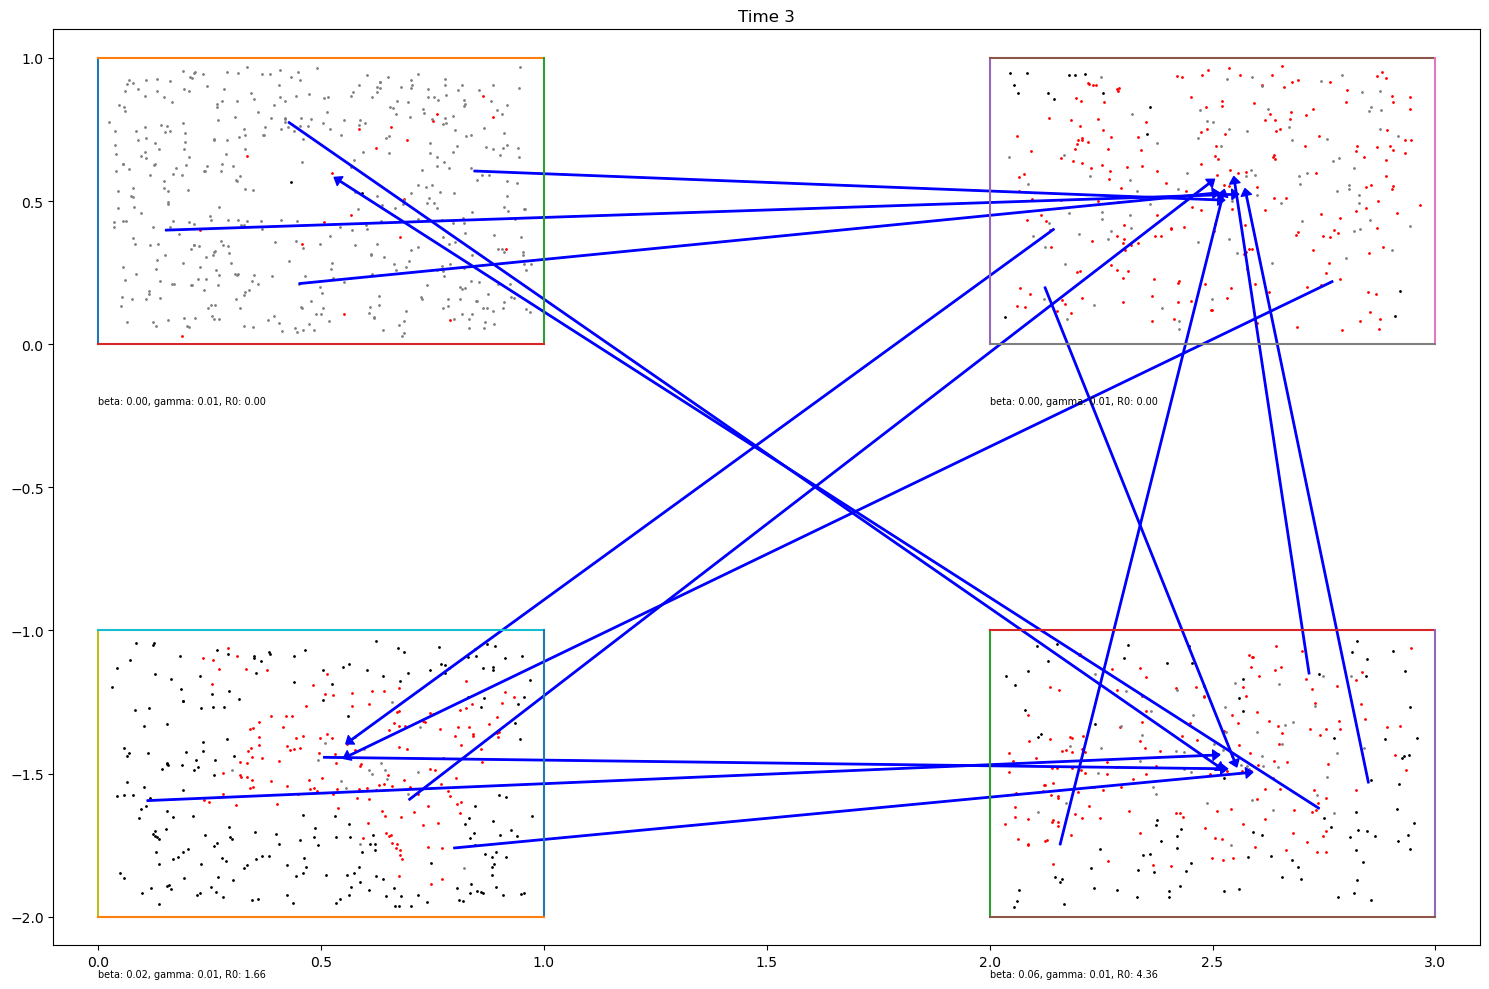

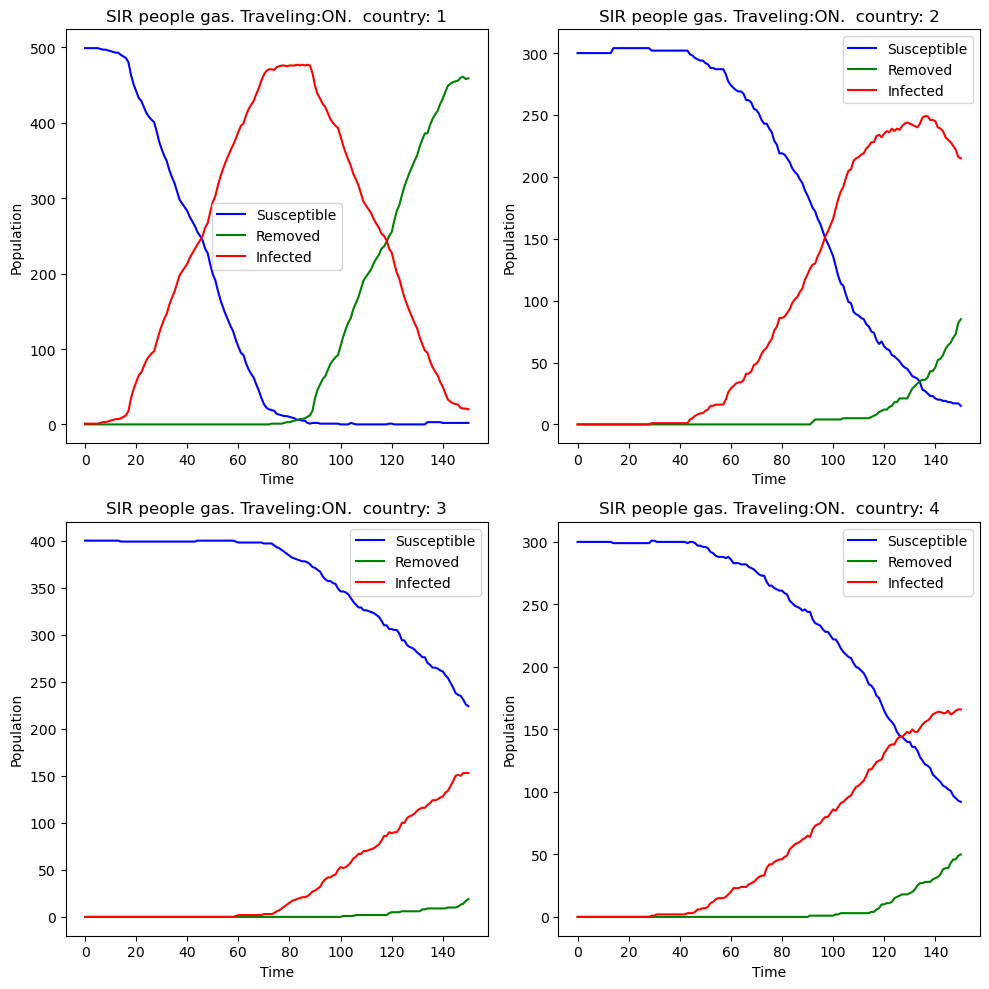

In [13]:
nHoursADay = 24
v1 = 0.01;v2 = 0.01;v3 = 0.01;v4 = 0.01;rotate_time = 5

#parameters_of_the_world
N1 = 500;edge_pos1 = np.array([0.,0.]); Lx1 = 1; Ly1 = 1; 
N2 = 300;edge_pos2 = np.array([2.,0.]); Lx2 = 1; Ly2 = 1; 
N3 = 400;edge_pos3 = np.array([0,-2]); Lx3 = 1; Ly3 = 1; 
N4 = 300;edge_pos4 = np.array([2.,-2]); Lx4 = 1; Ly4 = 1;

#virus_parameters
infect_radius = np.sqrt(Lx1*Ly1/N1)/3;
recovery_time = 3*nHoursADay; infecting_rate = 0.8;

#atractor_parameters
atractors1 = [[[0.5,0.5],0.3,0.01]];switch_time1 = round(nHoursADay/2)
atractors2 = [[[1.5,0.5],0.3,0.01]];switch_time2 = round(nHoursADay/2)

parameters1 = (N1,edge_pos1,Lx1,Ly1,v1,rotate_time,recovery_time,infecting_rate,infect_radius,atractors1,switch_time1)
parameters2 = (N2,edge_pos2,Lx2,Ly2,v2,rotate_time,recovery_time,infecting_rate,infect_radius,atractors2,switch_time2)
parameters3 = (N3,edge_pos3,Lx3,Ly3,v3,rotate_time,recovery_time,infecting_rate,infect_radius)
parameters4 = (N4,edge_pos4,Lx4,Ly4,v4,rotate_time,recovery_time,infecting_rate,infect_radius)
title = ['SIR people gas. Traveling:ON. ' + f' country: {i+1}' for i in range(4)]

travel_time = 15;traveling_rate = 0.01

fps = 15; nSeconds = 10

world = World([parameters1,parameters2,parameters3,parameters4],travel_time,traveling_rate)

world(0).infect(world(0).list_of_suceptible[round(N1/2)])
#world(1).infect(world(1).list_of_suceptible[round(N2/2)])
#world(2).infect(world(2).list_of_suceptible[round(N3/2)])
#world(3).infect(world(3).list_of_suceptible[round(N4/2)])

fig, ax = plt.subplots()
world.animate_planet(fig,ax,fps,nSeconds,title = 'SIR people gas-Traveling.gif')

#Differential Equation Simulation

fig_model, ax_model = plt.subplots(2,2)
ax_model = [ax_model[0][0],ax_model[0][1],ax_model[1][0],ax_model[1][1]]
world.plot(ax_model,title) 

## Part 2 - SIRS model


The second segment of our simulation dives into the SIRS model, an extension of the SIR model that introduces a crucial additional parameter, denoted as $\delta$. In this enriched model, individuals who have recovered will eventually transition back to the "Susceptible" state after a certain duration, rendering them susceptible to reinfection.

The $\delta$ parameter signifies the ***immunity rate***. The reciprocal of $\delta$, that is 1/$\delta$, indicates the duration individuals retain immunity before becoming susceptible once again.

This nuanced parameterization enhances the model's realism, capturing the temporal aspect of immunity and allowing for the representation of recurrent infections over time.

Considering the dependency of $\delta$ on $R_0$, the equation becomes $R_0 = \frac{\beta}{\gamma+\delta}$. This equation mirrors our approach in the previous model, offering predictions about pandemic behavior:

1) $R_0 > 1$: Epidemic environment 
2) $R_0 = 1$: Endemic environment 
3) $R_0 < 1$: No spread of infection 


As with the SIR model, we commence the analysis with the differential equations:

\begin{align}
\dot S &= -\beta\frac{SI}{N} + \delta R \quad \text{(Rate of change of susceptible individuals)} \nonumber \\
\dot I &= \beta\frac{SI}{N} - \gamma I \quad \text{(Rate of change of infected individuals)} \nonumber \\
\dot R &= \gamma I - \delta R \quad \text{(Rate of change of recovered individuals)} \nonumber
\end{align}

These equations form the foundation for understanding the intricate dynamics of infectious diseases within a population, considering the interplay between susceptible (S), infected (I), and recovered (R) individuals, while accounting for the temporal nature of immunity in the SIRS model.

In [21]:
class Humanity_SIRS(Humanity):
    def __init__(self, N1, N2, infecting_rate, recovery_time, immunity_time,infect_radius): 
        super().__init__(N1, N2, recovery_time, infecting_rate)
        self.immunity_time = immunity_time
        self.list_of_recovered_people = {}
        self.healing_matrix = np.random.normal(self.recovery_time,self.recovery_time/5,size = (N1,N2))#1/np.random.exponential(1/self.recovery_time, size=(N1,N2))
        self.immunity_matrix = np.random.normal(self.immunity_time,self.immunity_time/10,size = (N1,N2))#1/np.random.exponential(1/self.immunity_time, size=(N1,N2))
        self.infect_radius = infect_radius
        self.list_of_susceptible = {}
        self.flag = True #if flag is true, we perform on each step reinfect method (this method infect new susceptible people)
        self.switch_time = 0 # it is the time at which flag changes for the first time
        
        
    def evolution(self):
        super().evolution()
        self.check_for_loss_of_immunity()
        if not self.flag and self.time % self.switch_time/2 == 1:
            self.flag = True
        self.reinfection()
        
    def check_for_loss_of_immunity(self):
        a = list(self.list_of_recovered_people.keys())
        for i in a:
            n, m = i
            if self.list_of_recovered_people[i] >= self.immunity_matrix[n][m]:
                self.lose_immunity(i)
            else:
                self.list_of_recovered_people[i] += 1
                
    def lose_immunity(self, place):
        n, m = place
        self.removed -= 1
        self.susceptible += 1
        self.state_matrix[n][m] = 0
        self.list_of_recovered_people.pop(place)
        self.list_of_susceptible.update({place: 0})
        
    def reinfection(self):
        if len(self.list_of_ill_people) < (self.N1*self.N2)/10:
            b = list(self.list_of_susceptible)
            if len(b) > 0 and self.flag: #when there are some susceptible AND the flag is equal to true
                self.infect(b[0]) 
                self.flag = False
                self.switch_time = self.time
                            
                         
    def heal(self, place):
        super().heal(place)
        self.list_of_recovered_people.update({place: 0})
    
    def plot(self, ax):
        ax.plot(self.susceptible_history, label='Susceptible', color='blue')
        ax.plot(self.infected_history, label='Infected', color='red')
        ax.plot(self.removed_history, label='Removed', color='green')    
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        

    
class Differential_SIRS(Differential_SIR): # Initialization of the class for solving differential equations 

    def sir_model(self, y, t, beta, gamma, delta): # Function defining the SI model differential equations
        S, I, R = y
        b = beta[int(t)] if isinstance(beta,list) else beta
        dSdt = -b * S * I/self.N + delta * R
        dIdt = b * S * I/self.N - gamma * I
        dRdt = gamma * I - delta * R
        return [dSdt, dIdt, dRdt]

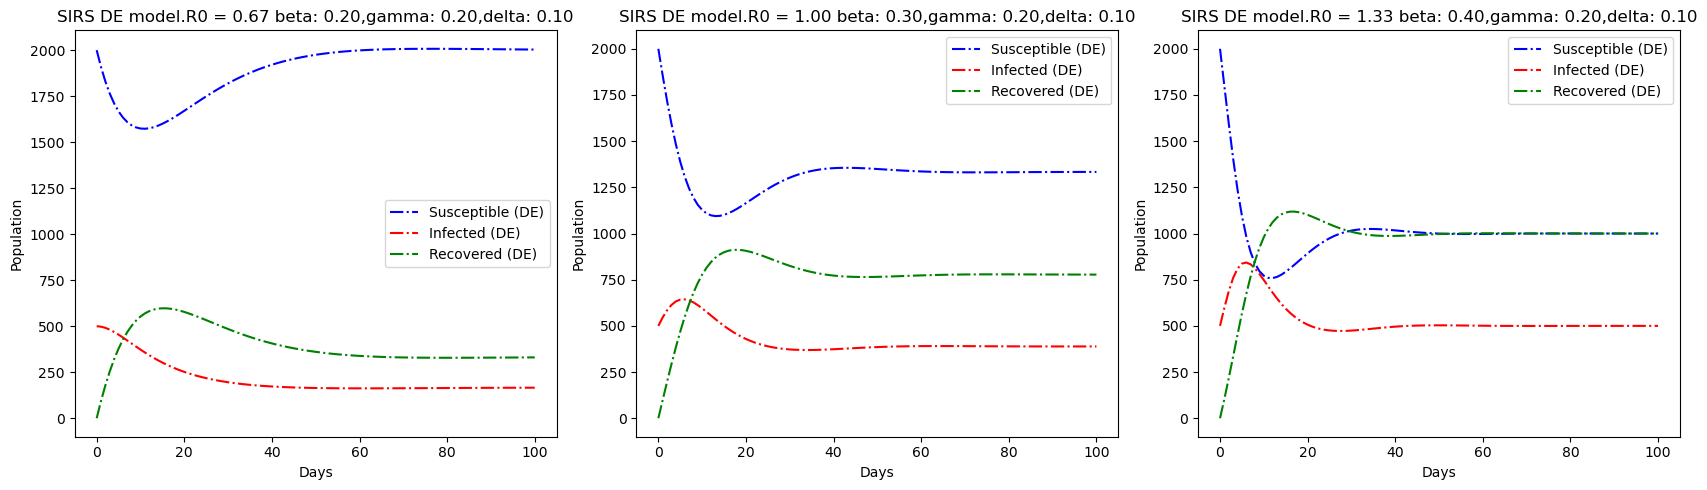

In [22]:
N1 = 50
N2 = 50
fig, ax_model = plt.subplots(1, 3, figsize=(17, 5), sharex=True)

# virus_parameters:
infecting_rate = 0.3
recovery_time = 5
immunity_time = 10
beta_sirs = [infecting_rate-0.1,infecting_rate,infecting_rate+0.1]
gamma_sirs = [1 / recovery_time-0.1,1 / recovery_time,1 / recovery_time +0.1]
delta_sirs = [1/ immunity_time-0.01,1/ immunity_time,1/ immunity_time+0.01]

#Differential Equation Simulation
Diff_eqn_sirs = Differential_SIRS(N1*N2-500, initial_infected=500)

for i in range(3):Diff_eqn_sirs.run_simulation(beta_sirs[i], gamma_sirs[1],delta=delta_sirs[1], days= 100,\
ax = ax_model[i],title = f'SIRS DE model.R0 = {beta_sirs[i]/(gamma_sirs[1]+delta_sirs[1]):.2f} beta: {beta_sirs[i]:.2f},\
gamma: {gamma_sirs[1]:.2f},delta: {delta_sirs[1]:.2f}', label_suffix='(DE)')


plt.subplots_adjust(hspace=0.4)
plt.show()

The plotted data reveals that when the basic reproduction number (R0) surpasses 1, the epidemic undergoes substantial spread, leading to a notable peak in the count of infected individuals. Additionally, the SIRS model exhibits a non-zero constant value for the infected population, and here the recovery and immunity rates set as constants.

MovieWriter ffmpeg unavailable; using Pillow instead.


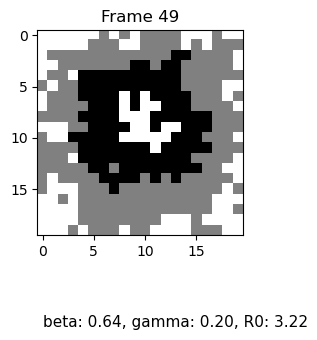

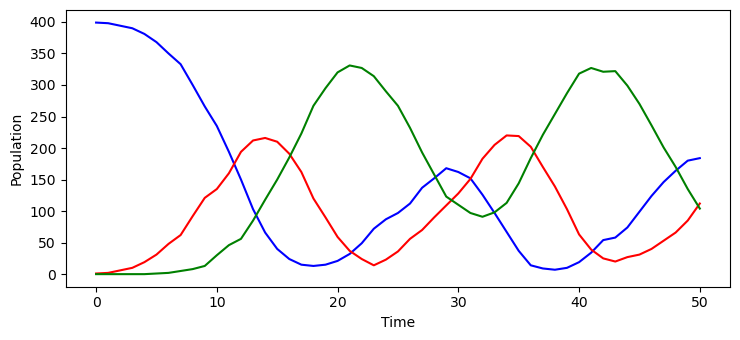

In [23]:
# Real Simulation
N1 = 20
N2 = 20
# virus_parameters:
infecting_rate = 0.3
recovery_time = 5
immunity_time = 10
infect_radius = 3

fig, ax, =  plt.subplots(1,1)

people = Humanity_SIRS(N1, N2, infecting_rate, recovery_time, immunity_time,infect_radius)
people.infect((round(N1/2),round(N2/2)))
#people.infect((30,50))
#people.infect((10,20))
fps = 10; nSeconds = 5; title = "SIRS matrix model.gif"
people.run_model(fig, ax,fps, nSeconds,title)
fig_model, ax_model = plt.subplots(1,1)
people.plot(ax_model)


This plot shows some oscillations and deviations from convergence to straight line. This behavior is happening because, in the matrix model, the infection rate (beta) is changing dynamically. Unlike the simpler SIR model, the SIRS model introduces more complexity by allowing infection and recovery rates to vary. This complexity leads to dynamic fluctuations, which is evident in the oscillations observed in the plot.